In [1]:
using Plots,QuadGK,LaTeXStrings,LinearAlgebra;
import NLsolve;

In [2]:
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [3]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [4]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

# Analytical continuation of self-energy

In [5]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [6]:
function Einner(E,q,m1,m2,m3,m12)
    return E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
end

Einner (generic function with 1 method)

# Using contour as used in $a_1$

$\mu^2$ for $DD^*$: -0.0016670826352479656,0.0006318533591980965,-0.001762240181737474

In [7]:
scattercomplex!(zv;kwds...)=scatter!(real.(zv),imag.(zv),legend=false;kwds)
plotcomplex!(zv;kwds...)=plot!(real.(zv),imag.(zv),legend=false;kwds)

plotcomplex! (generic function with 1 method)

In [8]:
Γsmc(t,Λ,ω,V0)=t+im*V0*(1-exp(-t/ω))*(1-exp((t-Λ)/ω))
pplus(z,l,usq)=-l*z+√(-usq+l^2*(z^2-1))
pminus(z,l,usq)=-l*z-√(-usq+l^2*(z^2-1))

pminus (generic function with 1 method)

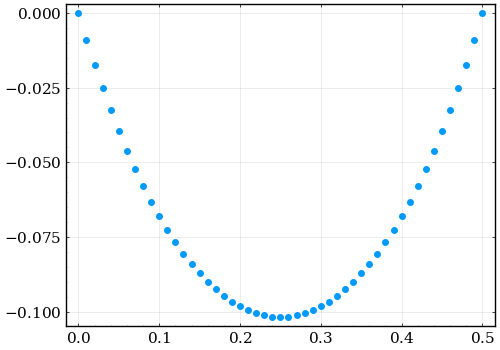

In [14]:
plot()
scattercomplex!([Γsmc(t,0.5,0.2,-0.2) for t in 0.0:0.01:0.5])

## test ope

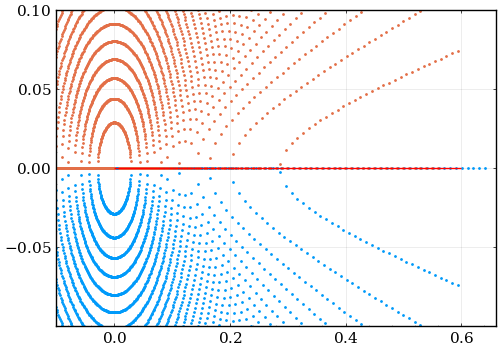

In [28]:
let lv=collect(0.0:0.01:0.6),zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l+0im,-0.0016670826352479656) for z in zv,l in lv])
    resv2=vec([pminus(z,l+0im,-0.0016670826352479656) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

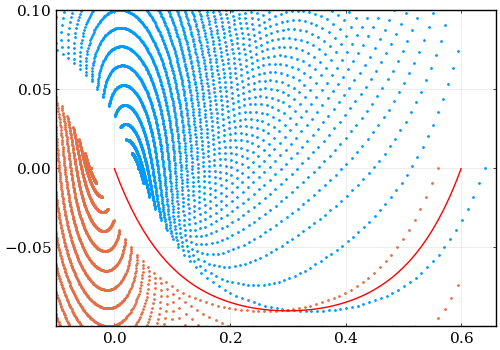

In [24]:
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,-0.0016670826352479656) for z in zv,l in lv])
    resv2=vec([pminus(z,l,-0.0016670826352479656) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

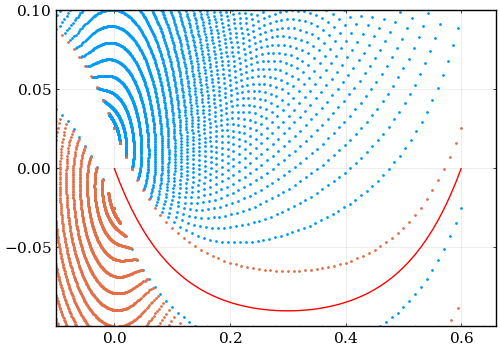

In [23]:
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,0.0006318533591980965) for z in zv,l in lv])
    resv2=vec([pminus(z,l,0.0006318533591980965) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

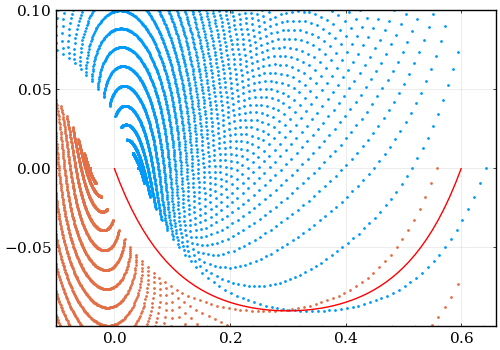

In [22]:
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l,-0.001762240181737474) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

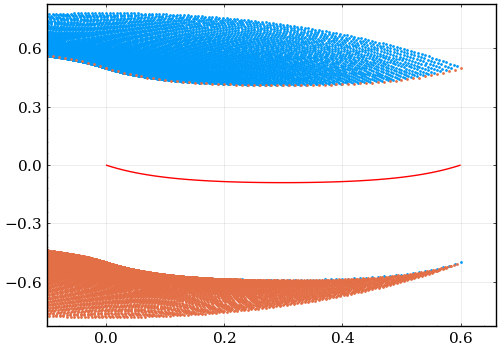

In [26]:
# heavier mesons
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,0.5^2) for z in zv,l in lv])
    resv2=vec([pminus(z,l,0.5^2) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

## test self-energy

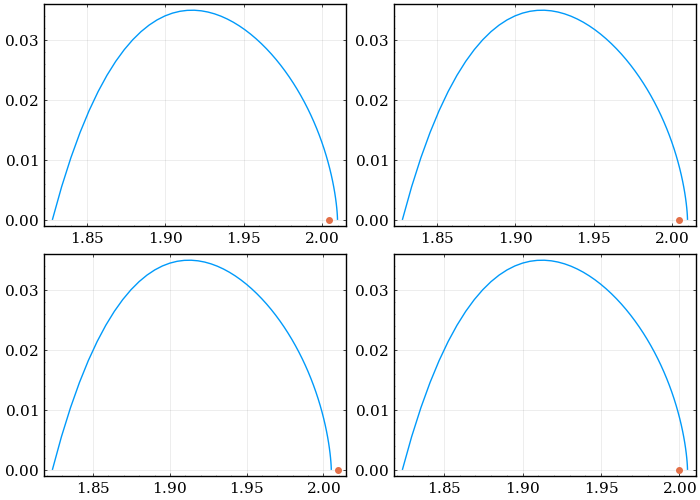

In [20]:
let 
    E=mDn+mDsc-360e-6-im*24e-6
#     E=3.875
    lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6]
    function plotf(E,m1,m2,m3,m12)
        plot()#xlims=(1.95,2.05),ylims=(-50e-6,50e-6))
        plotcomplex!([Einner(E,l,m1,m2,m3,m12) for l in lv])
        scatter!([m1+m2],[0])
    end
    plot(plotf(E,mDn,mπc,mDn,mDsc),plotf(E,mDc,mπn,mDn,mDsc),plotf(E,mDc,mπc,mDc,mDsn),plotf(E,mDn,mπn,mDc,mDsn),size=(700,500),layout=(2,2))
end

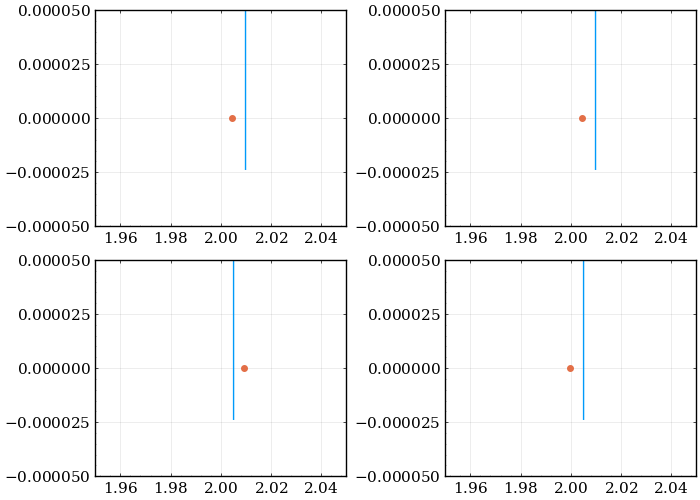

In [18]:
let 
    E=mDn+mDsc-360e-6-im*24e-6
#     E=3.875
    lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6]
    function plotf(E,m1,m2,m3,m12)
        plot(xlims=(1.95,2.05),ylims=(-50e-6,50e-6))
        plotcomplex!([Einner(E,l,m1,m2,m3,m12) for l in lv])
        scatter!([m1+m2],[0])
    end
    plot(plotf(E,mDn,mπc,mDn,mDsc),plotf(E,mDc,mπn,mDn,mDsc),plotf(E,mDc,mπc,mDc,mDsn),plotf(E,mDn,mπn,mDc,mDsn),size=(700,500),layout=(2,2))
end

## when integration momentum involved

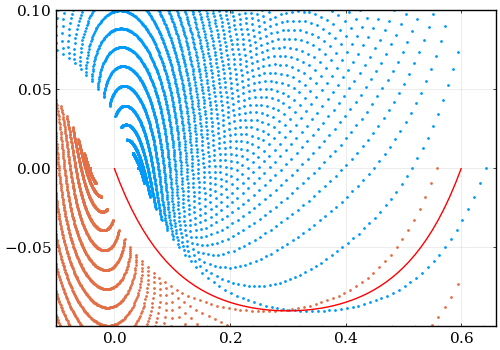

In [64]:
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l,-0.001762240181737474) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

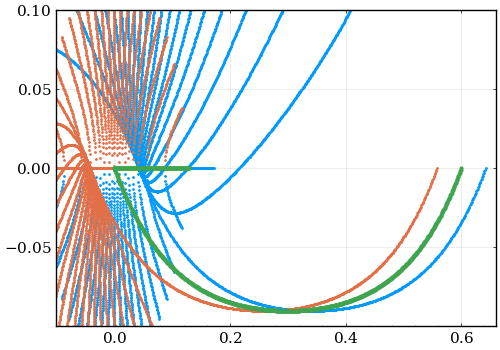

In [63]:
let 
    lv=vcat([Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.001:0.6],collect(0.0:0.001:0.13))
#     lv=collect(0.0:0.01:0.13)
    zv=collect(-1:0.1:1)
    resv1=vec([pplus(z,l+0im,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l+0im,-0.001762240181737474) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    scatter!(real.(lv),imag.(lv),lc=:red,markersize = 2)
end

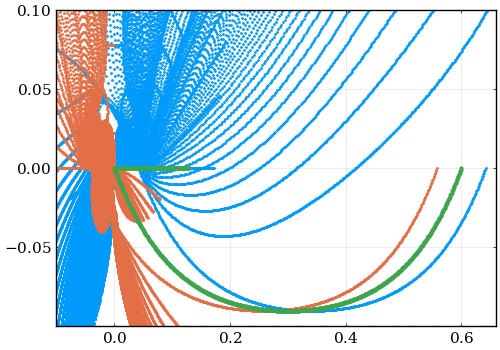

In [61]:
let 
    lv=vcat([Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.001:0.6],collect(0.0:0.001:0.13))
#     lv=collect(0.0:0.01:0.13)
    zv=vcat([-1-x*im for x in 0:0.1:10],[-1-10*im+x for x in 0.1:0.1:2],[1-10*im+im*x for x in 0.1:0.1:10])
    resv1=vec([pplus(z,l+0im,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l+0im,-0.001762240181737474) for z in zv,l in lv])
    plot()
    scatter!(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    scatter!(real.(lv),imag.(lv),lc=:red,markersize = 2)
end

# Testing

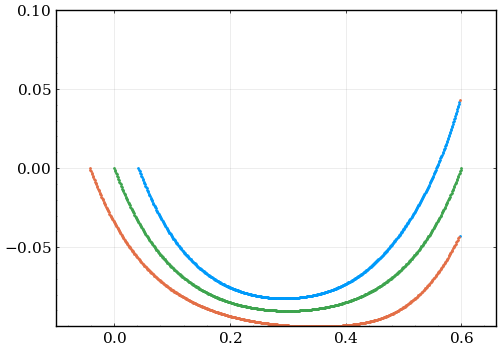

In [73]:
let 
    lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.001:0.6]
#     lv=collect(0.0:0.01:0.13)
    zv=[-0.995]
    resv1=vec([pplus(z,l+0im,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l+0im,-0.001762240181737474) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    scatter!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

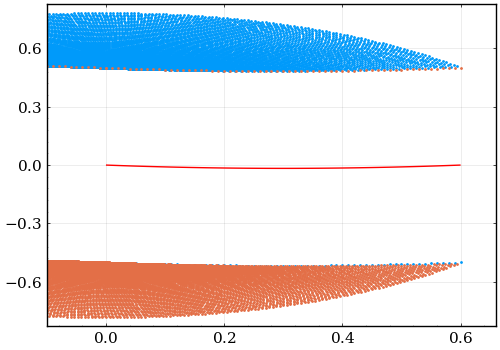

In [82]:
let lv=[Γsmc(t,0.6,5.0,-5.0) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,0.5^2) for z in zv,l in lv])
    resv2=vec([pminus(z,l,0.5^2) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

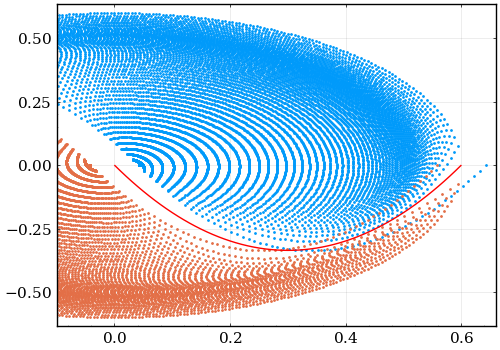

In [99]:
let lv=[Γsmc(t,0.6,1.0,-5.0) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l,-0.001762240181737474) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

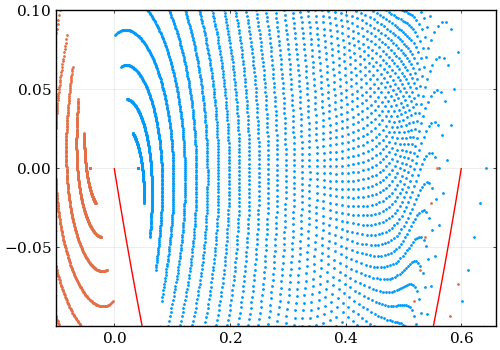

In [97]:
let lv=[Γsmc(t,0.6,1.0,-5.0) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l,-0.001762240181737474) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6),ylims=(-0.1,0.1))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

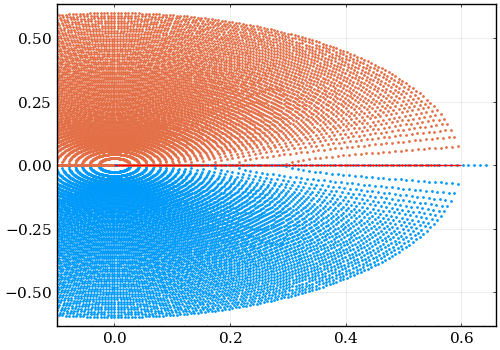

In [100]:
let lv=[Γsmc(t,0.6,1.0,0.0) for t in 0.0:0.01:0.6],zv=collect(-1:0.01:1)
    resv1=vec([pplus(z,l,-0.001762240181737474) for z in zv,l in lv])
    resv2=vec([pminus(z,l,-0.001762240181737474) for z in zv,l in lv])
    scatter(real.(resv1),imag.(resv1),lc=:blue,markersize = 1,legend=:false,xlims=(-0.1,1.1*0.6))
    scatter!(real.(resv2),imag.(resv2),lc=:blue,markersize = 1)
    plot!(real.(lv),imag.(lv),lc=:red,markersize = 1)
end

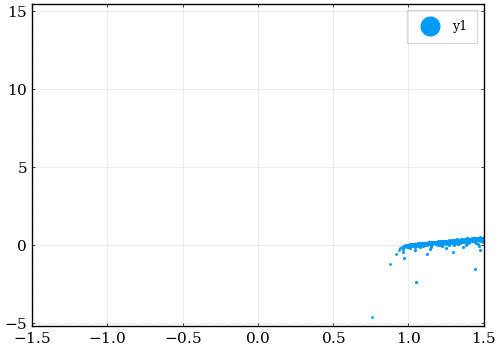

In [105]:
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6]
    zv=vec([(li^2+lj^2-0.001762240181737474)/(2*li*lj) for li in lv,lj in lv])
    scatter(real.(zv),imag.(zv),markersize=1,xlims=(-1.5,1.5))
end

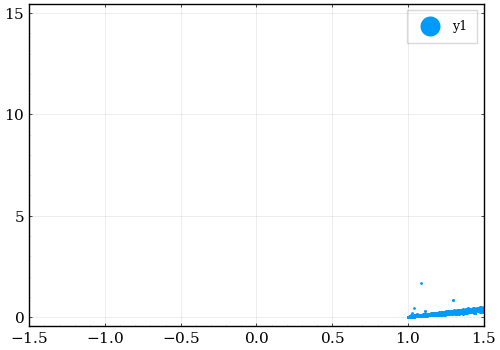

In [106]:
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6]
    zv=vec([(li^2+lj^2+0.0006318533591980965)/(2*li*lj) for li in lv,lj in lv])
    scatter(real.(zv),imag.(zv),markersize=1,xlims=(-1.5,1.5))
end

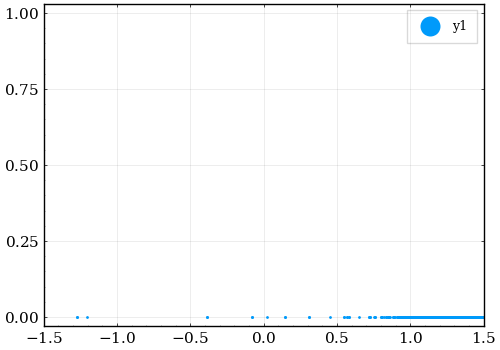

In [108]:
let lv=[Γsmc(t,0.6,0.1,0.0) for t in 0.0:0.01:0.6]
    zv=vec([(li^2+lj^2-0.001762240181737474)/(2*li*lj) for li in lv,lj in lv])
    scatter(real.(zv),imag.(zv),markersize=1,xlims=(-1.5,1.5))
end

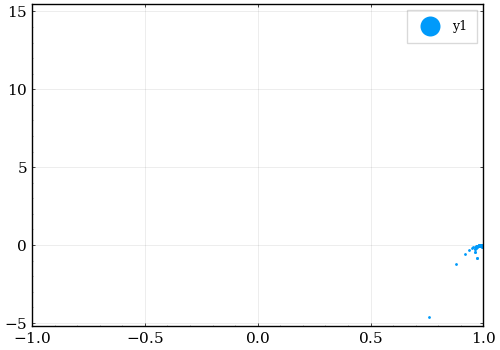

In [117]:
let lv=[Γsmc(t,0.6,0.1,-0.1) for t in 0.0:0.01:0.6]
    zv=vec([(li^2+lj^2-0.001762240181737474)/(2*li*lj) for li in lv,lj in lv])
    scatter(real.(zv),imag.(zv),markersize=1,xlims=(-1,1))
end